In [10]:
import tensorflow.keras as keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import pandas as pd
import json
import tensorflow as tf
import matplotlib.pyplot as plt


In [11]:

# Load the CSV file
df = pd.read_csv("C:/Users/Administrator/Downloads/Compressed/Task 2 bodymesurment/archive/body.csv")

# Load the images and measurements
images = []
measurements = []
measurement_names = []  # List to store the measurement names
for index, row in df.iterrows():
    selfie = Image.open(row['selfie'])
    front = Image.open(row['front'])
    side = Image.open(row['side'])
    with open(row['measurements'], 'r') as f:
        measurement = json.load(f)
    # Remove '_tbr' from all measurement values
    measurement = {k: v.replace('_tbr', '') if isinstance(v, str) else v for k, v in measurement.items()}
    # Convert the measurements to numbers
    measurement = {k: float(v) for k, v in measurement.items() if k != 'gender' and k != 'race' and k != 'profession'}
    # Encode 'male' as 1 and 'female' as 0, if 'gender' key exists
    if 'gender' in measurement:
        measurement['gender'] = 1.0 if measurement['gender'] == 'male' else 0.0
    images.append((selfie, front, side))
    measurements.append(list(measurement.values()))
    measurement_names.append(list(measurement.keys()))  # Store the measurement names

# Convert the measurements to a numpy array
measurements = np.array(measurements)

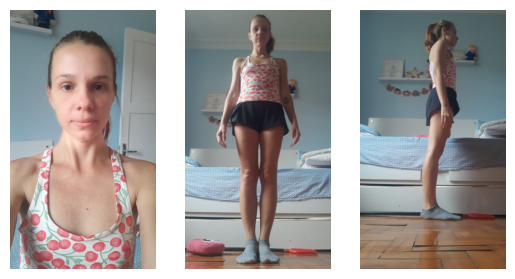

array([ 24.,  55.,  33.,  34.,  79.,  77.,  31.,  70.,  95.,  33.,  54.,
        41.,  44.,  88.,  14.,  40.,  49.,  71.,  29.,  68., 159.,  49.,
        34.])

In [12]:

import matplotlib.pyplot as plt

# Assuming images is your tuple of PIL images
imagess = images[0]
# Create a new figure
plt.figure()

# Loop over the images and display each one
for i, image in enumerate(imagess, start=1):
    plt.subplot(1, len(imagess), i)
    plt.imshow(image)
    plt.axis('off')  # Hide the axis

# Show the figure with the images
plt.show()
measurements[0]


In [13]:
import cv2
import mediapipe as mp

# Initialize MediaPipe Selfie Segmentation.
mp_selfie_segmentation = mp.solutions.selfie_segmentation.SelfieSegmentation(model_selection=1)

def segment_selfie(image):
    # Convert the PIL Image to a numpy array
    image = np.array(image)
    # Convert the RGB image to BGR
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # Process the image and get the segmentation results.
    result = mp_selfie_segmentation.process(image_bgr)
    # Generate a mask using the segmentation results.
    mask = result.segmentation_mask > 0.5
    # Broadcast the mask to have the same shape as the image.
    mask = np.stack((mask,) * 3, axis=-1)
    # Apply the mask to the image.
    segmented_image = np.where(mask, image, 0)
    return segmented_image



In [14]:
# Preprocess the images
images = [(segment_selfie(selfie), segment_selfie(front), segment_selfie(side)) for selfie, front, side in images]


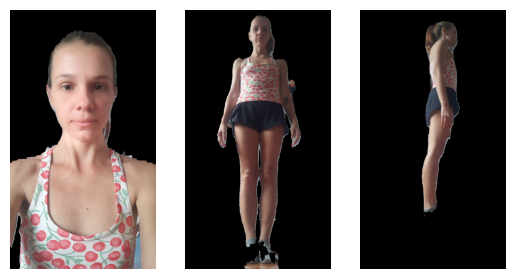

array([ 24.,  55.,  33.,  34.,  79.,  77.,  31.,  70.,  95.,  33.,  54.,
        41.,  44.,  88.,  14.,  40.,  49.,  71.,  29.,  68., 159.,  49.,
        34.])

In [15]:
# Assuming images is your tuple of PIL images
imagess = images[0]
# Create a new figure
plt.figure()

# Loop over the images and display each one
for i, image in enumerate(imagess, start=1):
    plt.subplot(1, len(imagess), i)
    plt.imshow(image)
    plt.axis('off')  # Hide the axis

# Show the figure with the images
plt.show()
measurements[0]

In [16]:
# Define a function to preprocess the images
def preprocess_image(image):
    # Convert the numpy array to a PIL Image
    image = Image.fromarray((image * 255).astype(np.uint8))
    # Resize the image
    image = image.resize((128, 128))
    # Convert the image to RGB
    image = image.convert('RGB')
    # Convert the image to a numpy array and normalize
    return np.array(image, dtype=np.float32) / 255

# Preprocess the images
preprocessed_images = [(preprocess_image(selfie), preprocess_image(front), preprocess_image(side)) for selfie, front, side in images]

# Convert the list of tuples to a numpy array with dtype=float32
images = np.array(preprocessed_images, dtype=np.float32)


In [29]:

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from keras.layers import BatchNormalization, Dropout
# Define the CNN for one image
def create_cnn(input_shape):
    inputs = Input(input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    return Model(inputs, x)

# Create three CNNs
cnn_selfie = create_cnn(images[0][0].shape)
cnn_front = create_cnn(images[0][1].shape)
cnn_side = create_cnn(images[0][2].shape)

# Concatenate the outputs of the three CNNs
concatenated = Concatenate()([cnn_selfie.output, cnn_front.output, cnn_side.output])

# Add a dense layer for the measurements
outputs = Dense(len(measurements[0]), activation='linear')(concatenated)

# Create the model
model = Model([cnn_selfie.input, cnn_front.input, cnn_side.input], outputs)


In [30]:

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Convert images and measurements to numpy arrays
images = np.array(images)
measurements = np.array(measurements)
# Train the model
model.fit([np.stack(images[:, 0]), np.stack(images[:, 1]), np.stack(images[:, 2])], measurements, epochs=10, batch_size=32)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step - loss: 4900.0840
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 4889.5010
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 4871.2285
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 4858.9336
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 4868.8496
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 4874.8247
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 4862.4082
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 4874.3960
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 4862.1992
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 4860.8760


In [32]:

# Save the model
model.save('C:/Users/Administrator/Documents/JOBSICENSE/Mywork Project/body_measurement_estimator.keras')
